## Decomposition Analysis of Index of Multiple Deprivation (IMD) Based on Shapley Value

In [2]:
import shap
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import math
from sortedcontainers import SortedList
import geopandas as gp
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import linear_model

The data can be found from Ministry of Housing, Communities & Local Government in the [link:](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/845345/File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv)


In [3]:
# read the data
IndicesPd=pd.read_csv("File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv")
#IndicesPd = pd.read_excel("File_5_-_IoD2019_ScoresM.xlsx", sheet_name="IoD2019 Scores", header= 0)

In [4]:
# get the column names
IndicesPd.columns

Index(['LSOA code (2011)', 'LSOA name (2011)',
       'Local Authority District code (2019)',
       'Local Authority District name (2019)',
       'Index of Multiple Deprivation (IMD) Score',
       'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)',
       'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
       'Income Score (rate)', 'Income Rank (where 1 is most deprived)',
       'Income Decile (where 1 is most deprived 10% of LSOAs)',
       'Employment Score (rate)', 'Employment Rank (where 1 is most deprived)',
       'Employment Decile (where 1 is most deprived 10% of LSOAs)',
       'Education, Skills and Training Score',
       'Education, Skills and Training Rank (where 1 is most deprived)',
       'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)',
       'Health Deprivation and Disability Score',
       'Health Deprivation and Disability Rank (where 1 is most deprived)',
       'Health Dep

In [5]:
# save the columns we need to a new dataframe
X=pd.DataFrame()
X['income_scores'] =IndicesPd['Income Score (rate)']
X['income_rank'] =  32845-IndicesPd['Income Rank (where 1 is most deprived)']
X['employment_scores'] = IndicesPd['Employment Score (rate)']
X['employment_rank'] =  32845-IndicesPd['Employment Rank (where 1 is most deprived)']
X['edu_scores'] = IndicesPd['Education, Skills and Training Score']
X['edu_rank'] =  32845-IndicesPd['Education, Skills and Training Rank (where 1 is most deprived)']
X['health_scores'] = IndicesPd['Health Deprivation and Disability Score']
X['health_rank'] =  32845-IndicesPd['Health Deprivation and Disability Rank (where 1 is most deprived)']
X['crime_scores'] = IndicesPd['Crime Score']
X['crime_rank'] =  32845-IndicesPd['Crime Rank (where 1 is most deprived)']
X['house_scores'] = IndicesPd['Barriers to Housing and Services Score']
X['house_rank'] =  32845-IndicesPd['Barriers to Housing and Services Rank (where 1 is most deprived)']
X['live_scores']=IndicesPd['Living Environment Score']
X['live_rank']= 32845-IndicesPd['Living Environment Rank (where 1 is most deprived)']
X

income_scores  income_rank  employment_scores  employment_rank  \
0              0.007           14              0.010              103   
1              0.034         2944              0.027             1655   
2              0.086        14335              0.086            17742   
3              0.211        26816              0.136            25012   
4              0.117        18822              0.059            11153   
...              ...          ...                ...              ...   
32839          0.470        32755              0.341            32669   
32840          0.362        32007              0.280            32145   
32841          0.099        16415              0.073            14841   
32842          0.396        32403              0.291            32295   
32843          0.273        29738              0.227            30864   

       edu_scores  edu_rank  health_scores  health_rank  crime_scores  \
0           0.024         3         -1.654          732        -2.012   
1           0.063        13         -1.115         3140        -2.343   
2           5.804      6459         -0.102        15245        -1.032   
3          22.260     20475         -0.121        14938        -1.317   
4          14.798     15334         -0.359        11264        -0.147   
...           ...       ...            ...          ...           ...   
32839      73.723     32280          2.361        32732         1.316   
32840      59.571     31064          1.665        31903         1.015   
32841      11.133     12074          0.823        27151         0.054   
32842      64.836     31637          1.828        32246         0.314   
32843      18.633     18170          1.768        32126         1.445   

       crime_rank  house_scores  house_rank  live_scores  live_rank  
0             183        29.472       25526       31.873      25056  
1              56        24.412       21138       23.084      19775  
2            3482        40.103       30688       40.535      28753  
3            1786        39.900       30628       28.979      23448  
4           13997        45.171       31812       26.888      22216  
...           ...           ...         ...          ...        ...  
32839       31157        16.867       12247       20.426      17892  
32840       29443        19.411       15466       12.584      11414  
32841       17013         4.477         617       58.942      32067  
32842       21117        11.968        6248       57.424      31930  
32843       31631        20.646       16956       53.451      31473  

[32844 rows x 14 columns]

In [6]:
# According to the true rank(from ONS)，change the domain scores slightly so that we can get the rank directly from the scores.

for i in range(0, 14, 2):# the sequence of i are:'income_scores', 'income_rank', 'employment_scores', 'employment_rank', 'edu_scores',
#'edu_rank', 'health_scores', 'health_rank','crime_scores', 'crime_rank', 'house_scores', 'house_rank',  'live_scores', 'live_rank'
    scores=X.columns[i]
    ranks=X.columns[i+1]
    X.sort_values(by = ranks, inplace=True)# this step ensure that we can add 1e-6 directly in sequence for the same scores in the last step
    part_df=X.iloc[:,[i, i+1]]# each time select two columns from the same domain: a column for scores and a column for ranks
    part_df_count=part_df[scores].value_counts()
    #print("part_df_count.head(1)") #check how many the same scores are there，the largest one is within 300
    #the original scores have three decimals, thus we choose to add 1e-6 each time for the same score.
    
    for score in part_df_count.index:
        if part_df_count[score]==1:# if there are no same score as the current one, break the loop. it helps to reduces the time to run.
            break
        else:
            score_df=part_df[part_df[scores]==score][scores]
            index=score_df.index #get the index of these same scores
            X.loc[index, scores]=[num + i * 1e-6 for i, num in enumerate(score_df)]

In [7]:
# choose the 7 domain scores we need and save in X1
X1 = X.filter(regex="scores$",axis=1).copy(deep=True)

In [8]:
#sort the index and save it
X1=X1.sort_index()
X1.describe()

income_scores  employment_scores    edu_scores  health_scores  \
count   32844.000000       32844.000000  32844.000000   32844.000000   
mean        0.128235           0.100016     21.691084       0.000004   
std         0.093507           0.067396     18.607562       0.859655   
min         0.003000           0.002000      0.013000      -3.215000   
25%         0.056184           0.050241      7.360001      -0.593986   
50%         0.099124           0.080027     16.180500      -0.026996   
75%         0.178010           0.133006     30.906500       0.577000   
max         0.609000           0.534000     99.446000       3.547000   

       crime_scores  house_scores   live_scores  
count  32844.000000  32844.000000  32844.000000  
mean       0.000003     21.691081     21.691081  
std        0.815101     10.711301     15.202485  
min       -3.459000      0.483000      0.126000  
25%       -0.563993     13.655500      9.447001  
50%        0.016012     20.196500     18.512000  
75%        0.564000     28.266250     31.078500  
max        3.350000     70.456000     91.602000

# Q1: Do we need to have a table like X1.describe() to introduce our data?
# Q2: Do the following procedure need to be write in detail in the word, like how we transform the data so that we can rank it and provide some example of what the data has changed, or just roughly describe them?

In [9]:
# create a list of list(lol) to store the ranked scores.
lol=[]
for i in range(7):
    l = SortedList()
    l.update(X1.iloc[:,i])
    lol.append(l)
lol[0].index(0.003) # a sortedList.index(a specific score) can return the corresponding rank of the score in the sortedList

0

In [10]:
#The function  that transform 7 domain scores to IMD score

def transform(rows):
    IMDs=[]
    for row in rows:
        rankRow=[]
        for i in range(len(row)):    
            lol[i].add(row[i])
            rankRow.append(lol[i].index(row[i])+ 1)
            lol[i].remove(row[i])#it will remove only an item even there are many scores that equal to the value of row[i]
        rankRow=np.array(rankRow)
       # print(rankRow)
        x=-23*np.log((1-rankRow/32844*(1-math.exp(-100/23))))
        IMD = np.dot(np.array([0.225,0.225,0.135,0.135,0.093,0.093,0.093]),np.array(x).T)
        IMDs.append(IMD)
    IMDs= np.array(IMDs)
        # IMD = pd.DataFrame({"IMD":np.dot(np.array([0.225,0.225,0.135,0.135,0.093,0.093,0.093]),np.array(x).T)})
    return IMDs

In [11]:
# check the difference between the calculated IMD scores and the real IMD scores(from ONS)
for i in range(10):
    IMD = transform(X1.values[i].reshape(1,-1))
    y = IndicesPd["Index of Multiple Deprivation (IMD) Score"]
    print(y.values[i]-IMD)

[0.00025943]
[-3.75646897e-05]
[0.00031496]
[0.00011703]
[-0.00016147]
[-0.00018464]
[2.74339847e-05]
[4.12025657e-05]
[0.00038857]
[0.0003714]


In [12]:
reference=X1.mean().T.values.reshape(1,-1)

In [13]:
X1.values[0:3]

array([[ 7.0010000e-03,  1.0024000e-02,  2.4000000e-02, -1.6540000e+00,
        -2.0120000e+00,  2.9472001e+01,  3.1873000e+01],
       [ 3.4210000e-02,  2.7173000e-02,  6.3001000e-02, -1.1150000e+00,
        -2.3430000e+00,  2.4412001e+01,  2.3084000e+01],
       [ 8.6112000e-02,  8.6043000e-02,  5.8040010e+00, -1.0199100e-01,
        -1.0319990e+00,  4.0103000e+01,  4.0535000e+01]])

In [15]:


explainer = shap.KernelExplainer(transform, reference)
shap_values = explainer.shap_values(X1.values)

# print("shap_values =", shap_values)
print("base value =", explainer.expected_value)

In [14]:
#change the type numpy.array to DataFrame and save to a csv, 
#so that we can directly use the shap values and do not need to run the above process again
pd_data = pd.DataFrame(shap_values)
pd_data.to_csv('shap_values.csv',index= False)

NameError: name 'shap_values' is not defined

In [14]:
shap_csv=pd.read_csv('shap_values.csv')

shap_values=shap_csv.values

In [15]:
shap_values[:,0]

array([-4.81378075, -4.33655784, -1.89961888, ..., -1.29757989,
       14.03367503,  6.78472921])

In [16]:
# visualize the first row's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X1.iloc[0,:])

In [28]:
# visualize 
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X1.iloc[:1000,:])

Summary Plot is the interpretation of the prediction of all samples. There are two kinds of plots. One is to take the average absolute value of shap values of each feature to get the standard bar chart (just as follows), which is actually the global importance I.

![formula](https://www.zhihu.com/equation?tex=I_j%3D%5Csum_%7Bi%3D1%7D%5En%7C%5Cphi_j%5E%7B%28i%29%7D%7C)

From following plot, we can roughly see that the importance of Employment Score, Income Score are almost the same; the Education, Skills and Training Score's and the Health Deprivation and Disability Score's importance are similar; besides, the importance of the remaining three domine scores are also of the similar value. These seem to correspond to the weight distributed to the seven domains.

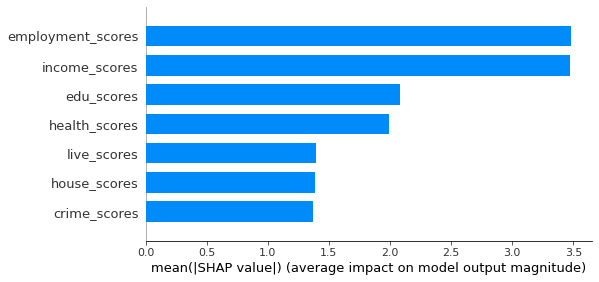

<Figure size 432x288 with 0 Axes>

In [154]:
shap.summary_plot(shap_values, X1, plot_type="bar")
plt.savefig('summary_plot')

The other is to simply draw the shap values of each feature of each sample through scattered points. The relationship between the feature value and its predicted influence can be seen. The distribution of the feature values can be displayed at the same time.

It's interesting that all the domains behave similar. When the feature values are low, they tend to contribute a negative effect to the final IMD score, while they lean to have positive Shapley value when they are large. Additionally, when feature value are low, they are more gathered which means the change of feature value will not obviously influene the Shapley value; when they are high, the distribution of them are more even and it seems that they follows a linear relation: a higher feature value corresponds to a larger Shapley value .


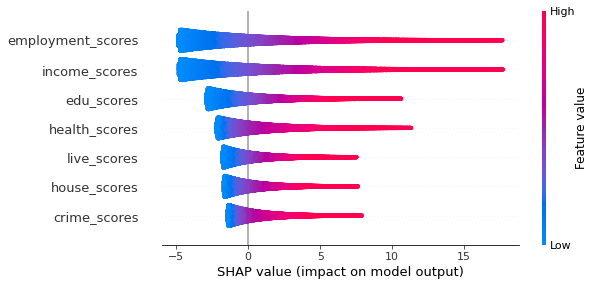

<Figure size 432x288 with 0 Axes>

In [155]:
shap.summary_plot(shap_values, X1)
plt.savefig('summary_plot_scatter')

The following dependence scatter plot gives us a more clear relationship between individual domain scores and their corresponding shapley values. In general, they have the similar tendency: it's super-linear at the begining. Then becomes linear and finally tends to be subliner.
For the first two plots, only the very begining part(just above 0) has super-linearity. Besides, when their score is larger than 0.3, it have the same result as the above figure get which is: a low score corresponds to a negative Shaplely value but a higher score indicates a positive one(for income and employment score,it's when the sore is more than 0.1).
Question: Do we need to describe each figure in detail?

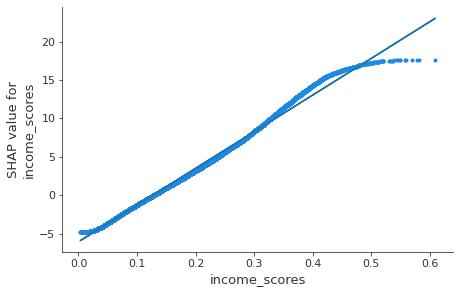

<Figure size 432x288 with 0 Axes>

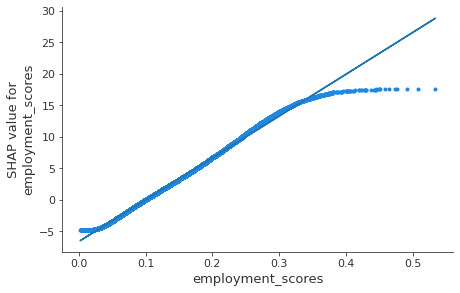

<Figure size 432x288 with 0 Axes>

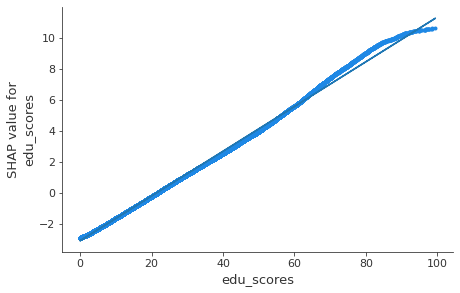

<Figure size 432x288 with 0 Axes>

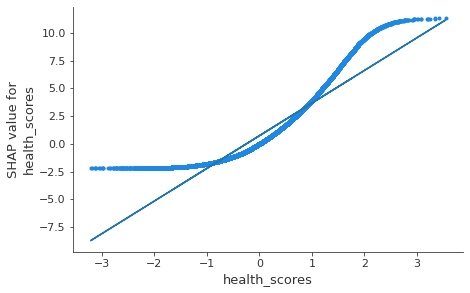

<Figure size 432x288 with 0 Axes>

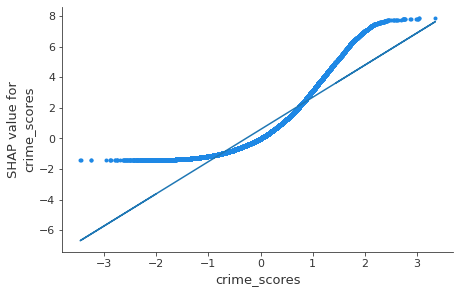

<Figure size 432x288 with 0 Axes>

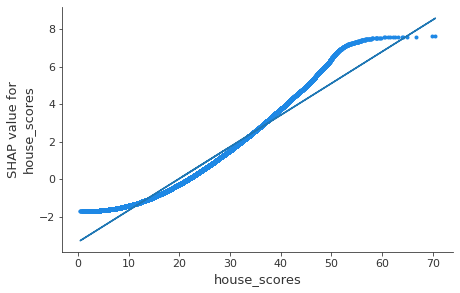

<Figure size 432x288 with 0 Axes>

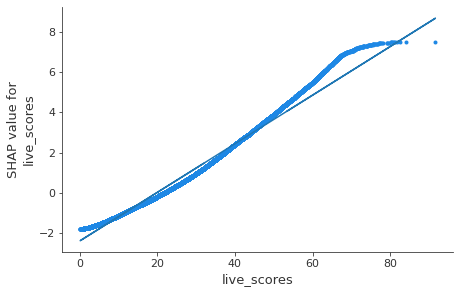

<Figure size 432x288 with 0 Axes>

In [146]:
import matplotlib.pyplot as plt
for i in range(len(X1.columns)):
    x=X1.iloc[:,i].values.reshape(-1, 1)
    y=shap_values[:,i].reshape(-1, 1)
    reg=linear_model.LinearRegression(fit_intercept=True,normalize=False)
    reg.fit(x,y)
    k=reg.coef_
    b=reg.intercept_
    y_pre=k*x+b
    fig, ax = plt.subplots(1,1, figsize=(7,4.5))
    ax.plot(x,y_pre)
    shap.dependence_plot(X1.columns[i], shap_values, X1, interaction_index=None, ax=ax) 
    plt.savefig(f'scatter {X1.columns[i]}')

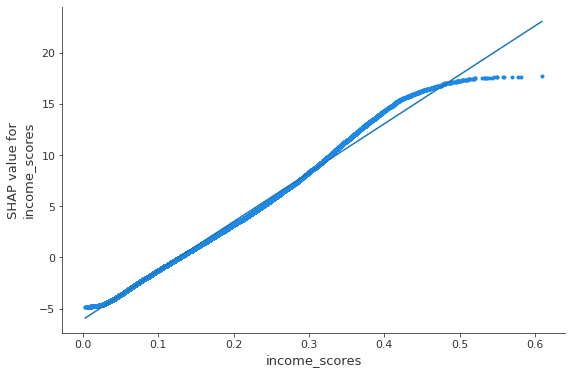

In [37]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.plot(np.unique(X1.income_scores), np.poly1d(np.polyfit(X1.income_scores,shap_values[:,0], 1))(np.unique(X1.income_scores)),color="red")
shap.dependence_plot('income_scores', shap_values, X1, interaction_index=None,ax=ax)
plt.show()

In [33]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = X1.columns
feature_importance['importance'] = np.abs(shap_values).mean(0)
feature_importance.sort_values('importance', ascending=False)

feature  importance
1  employment_scores    3.478560
0      income_scores    3.471475
2         edu_scores    2.079903
3      health_scores    1.991815
6        live_scores    1.395596
5       house_scores    1.384263
4       crime_scores    1.371781

The IMD combines information from the seven domains to produce an overall relative
measure of deprivation. The domains are combined using the following weights:

• Income Deprivation (22.5%)

• Employment Deprivation (22.5%)

• Education, Skills and Training Deprivation (13.5%)

• Health Deprivation and Disability (13.5%)

• Crime (9.3%)

• Barriers to Housing and Services (9.3%)

• Living Environment Deprivation (9.3%)

The weight for each domain calculated from the importance are as follows. Although there are some differences between the weight mentioned above and the calculated one (for the weight derived from importance, the first three domains are slightly higher and the remaining four are lower than the official one), the overall structure are similar.

In [34]:
feature_sum = feature_importance.importance.sum()
for i in feature_importance.feature:
    print(f"The weight of {i}: {feature_importance[feature_importance.feature==i].importance.values/feature_sum}")

The weight of income_scores: [0.22878702]
The weight of employment_scores: [0.22925395]
The weight of edu_scores: [0.13707566]
The weight of health_scores: [0.13127023]
The weight of crime_scores: [0.09040701]
The weight of house_scores: [0.0912296]
The weight of live_scores: [0.09197653]


In [35]:
feature_importance[feature_importance.feature=='income_scores'].importance


0    3.471475
Name: importance, dtype: float64

In [16]:
lsoa_boundry = gp.read_file("Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales/Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp")#读取


In [47]:
lsoa_boundry

objectid   lsoa11cd                   lsoa11nm  \
0             1  E01000001        City of London 001A   
1             2  E01000002        City of London 001B   
2             3  E01000003        City of London 001C   
3             4  E01000005        City of London 001E   
4             5  E01000006  Barking and Dagenham 016A   
...         ...        ...                        ...   
34748     34749  W01001954               Cardiff 006F   
34749     34750  W01001955               Swansea 025F   
34750     34751  W01001956               Swansea 023E   
34751     34752  W01001957               Swansea 025G   
34752     34753  W01001958               Swansea 025H   

                       lsoa11nmw    st_areasha    st_lengths  \
0            City of London 001A  1.333208e+05   2291.846072   
1            City of London 001B  2.261913e+05   2433.960112   
2            City of London 001C  5.730297e+04   1142.359799   
3            City of London 001E  1.907388e+05   2167.868343   
4      Barking and Dagenham 016A  1.441958e+05   1935.510354   
...                          ...           ...           ...   
34748              Caerdydd 006F  6.471879e+05   5353.810154   
34749              Abertawe 025F  6.900149e+05   5776.750473   
34750              Abertawe 023E  2.493308e+06  12586.351015   
34751              Abertawe 025G  2.144800e+05   2635.105196   
34752              Abertawe 025H  3.127378e+05   4785.840963   

                                                geometry  
0      POLYGON ((-0.09726 51.52158, -0.09649 51.52028...  
1      POLYGON ((-0.08810 51.51941, -0.08927 51.51752...  
2      POLYGON ((-0.09676 51.52325, -0.09644 51.52282...  
3      POLYGON ((-0.07320 51.51000, -0.07551 51.50974...  
4      POLYGON ((0.09118 51.53909, 0.09328 51.53787, ...  
...                                                  ...  
34748  POLYGON ((-3.25546 51.52101, -3.25489 51.51968...  
34749  POLYGON ((-3.94053 51.63059, -3.93913 51.62702...  
34750  POLYGON ((-4.02465 51.63615, -4.02458 51.63574...  
34751  POLYGON ((-3.94920 51.61754, -3.94814 51.61670...  
34752  POLYGON ((-3.93505 51.62182, -3.93146 51.61739...  

[34753 rows x 7 columns]

In [4]:
# cluster=pd.read_csv("cluster.csv")
# score_cluster=pd.read_csv("score_cluster.csv")

In [17]:
london=pd.read_csv("london_lsoa.csv")
london

lad11nm     lsoa11
0     City of London  E01000001
1     City of London  E01000002
2     City of London  E01000003
3     City of London  E01000005
4     City of London  E01032739
...              ...        ...
4830     Westminster  E01033604
4831     Westminster  E01033605
4832     Westminster  E01033606
4833     Westminster  E01033607
4834     Westminster  E01033608

[4835 rows x 2 columns]

In [128]:
# def cluster_plt(clusterdf, column_name):
#     lsoa_cluster = lsoa_boundry.join(clusterdf.set_index("Unnamed: 0"), on="lsoa11cd", how='right')
#     lsoa_cluster=lsoa_cluster.join(london.set_index("lsoa11"), on="lsoa11cd", how='left')
#     lsoa_cluster.to_crs("epsg:27700")
#     fig, ax = plt.subplots(1,1, figsize=(14,18))
#     lsoa_cluster.plot(edgecolor=None, column=column_name,linewidth=0.5, cmap='tab10', 
#              legend=True, ax=ax)
#     ax1 = fig.add_axes([0.11, 0.353, 0.29, 0.29])
#     lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(edgecolor=None, column=column_name, cmap='tab10', ax=ax1)
#     lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(facecolor='none', edgecolor='r',linewidth=0.05, ax=ax)
#     # plt.colorbar(fraction=0.05, pad=0.05)
#     ax.axis('off')
#     ax1.axis('off')

In [108]:
# lsoa_cluster[lsoa_cluster.lad11nm.notna()]

objectid   lsoa11cd                   lsoa11nm  \
0             1  E01000001        City of London 001A   
1             2  E01000002        City of London 001B   
2             3  E01000003        City of London 001C   
3             4  E01000005        City of London 001E   
4             5  E01000006  Barking and Dagenham 016A   
...         ...        ...                        ...   
32817     32818  E01033742             Greenwich 007F   
32818     32819  E01033743             Greenwich 002H   
32819     32820  E01033744             Greenwich 007G   
32820     32821  E01033745             Greenwich 002I   
32821     32822  E01033746             Greenwich 038E   

                       lsoa11nmw    st_areasha   st_lengths  \
0            City of London 001A  1.333208e+05  2291.846072   
1            City of London 001B  2.261913e+05  2433.960112   
2            City of London 001C  5.730297e+04  1142.359799   
3            City of London 001E  1.907388e+05  2167.868343   
4      Barking and Dagenham 016A  1.441958e+05  1935.510354   
...                          ...           ...          ...   
32817             Greenwich 007F  1.233092e+05  1860.310172   
32818             Greenwich 002H  1.004853e+06  5237.180226   
32819             Greenwich 007G  1.522620e+05  2149.370918   
32820             Greenwich 002I  5.584777e+05  4193.828349   
32821             Greenwich 038E  1.289767e+05  2367.405282   

                                                geometry  cluster  \
0      POLYGON ((-0.09726 51.52158, -0.09649 51.52028...        1   
1      POLYGON ((-0.08810 51.51941, -0.08927 51.51752...        7   
2      POLYGON ((-0.09676 51.52325, -0.09644 51.52282...        2   
3      POLYGON ((-0.07320 51.51000, -0.07551 51.50974...        3   
4      POLYGON ((0.09118 51.53909, 0.09328 51.53787, ...        2   
...                                                  ...      ...   
32817  POLYGON ((0.08243 51.49886, 0.08417 51.49803, ...        1   
32818  POLYGON ((0.11084 51.50980, 0.11230 51.50782, ...        2   
32819  POLYGON ((0.08075 51.49550, 0.08167 51.49491, ...        3   
32820  POLYGON ((0.10809 51.50135, 0.10667 51.50021, ...        3   
32821  POLYGON ((-0.01217 51.47792, -0.01236 51.47720...        8   

       Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)  \
0                                                      9                                    
1                                                     10                                    
2                                                      5                                    
3                                                      3                                    
4                                                      5                                    
...                                                  ...                                    
32817                                                  7                                    
32818                                                  5                                    
32819                                                  3                                    
32820                                                  4                                    
32821                                                  4                                    

                    lad11nm  
0            City of London  
1            City of London  
2            City of London  
3            City of London  
4      Barking and Dagenham  
...                     ...  
32817             Greenwich  
32818             Greenwich  
32819             Greenwich  
32820             Greenwich  
32821             Greenwich  

[4835 rows x 10 columns]

The distribution seems that rural and urban area are mixed. but the clustering result tend to like the surounding area

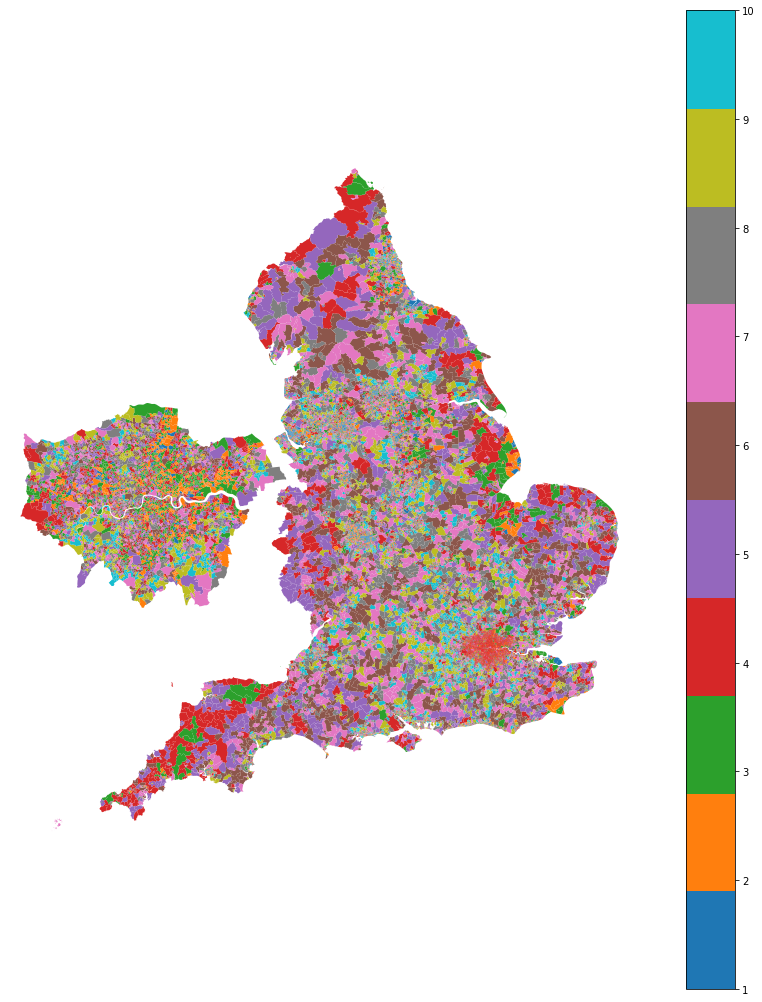

In [112]:
# visualization of IMD Decile where 1 is most deprived 10% of LSOAs
cluster_plt(cluster,"Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)" )

(-0.5524955479137468,
 0.37623931186597015,
 51.26650280670896,
 51.712131555049034)

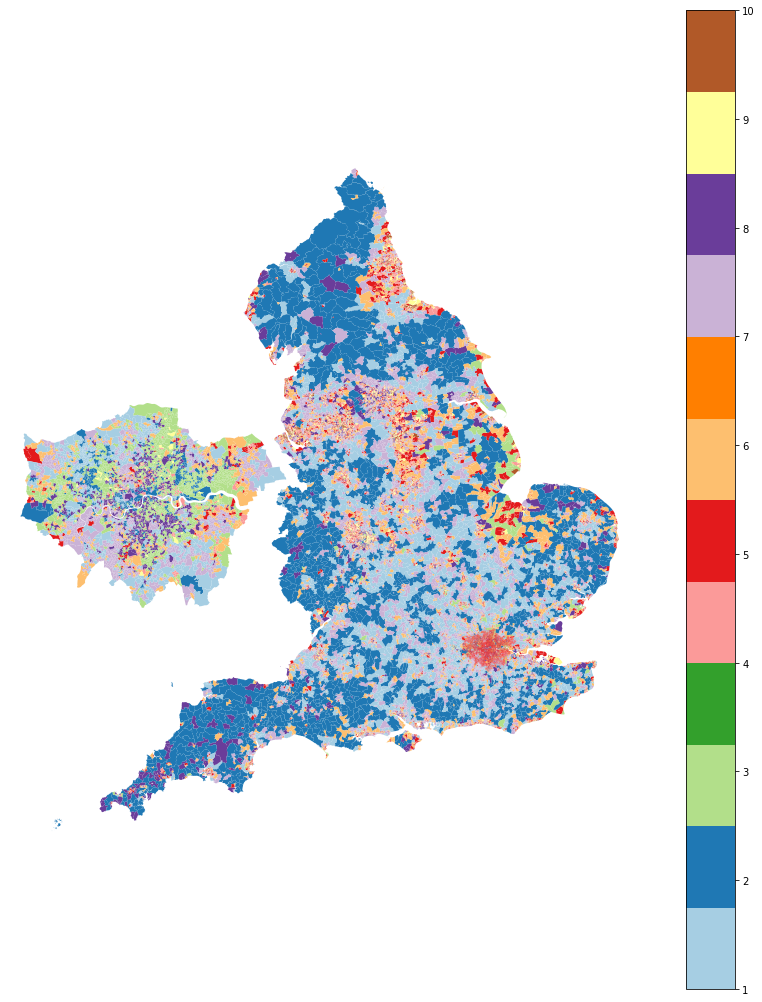

In [50]:
# fig, ax = plt.subplots(1,1, figsize=(14,18))
# lsoa_cluster.plot(edgecolor=None, column='cluster',linewidth=0.5, cmap='Paired', 
#              legend=True, ax=ax)
# ax1 = fig.add_axes([0.11, 0.353, 0.29, 0.29])
# lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(edgecolor=None, column='cluster', cmap='Paired', ax=ax1)
# lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(facecolor='none', edgecolor='r',linewidth=0.05, ax=ax)
# # plt.colorbar(fraction=0.05, pad=0.05)
# ax.axis('off')
# ax1.axis('off')

In [249]:
lsoa_cluster.cluster.value_counts()

2    18950
0    10002
1     3892
Name: cluster, dtype: int64

In [18]:
import matplotlib as mpl

In [ ]:
# cmap = plt.cm.Set3  # define the colormap
# # extract all colors from the .jet map
# cmaplist = [cmap(i) for i in range(1,4)]
# # force the first color entry to be grey
# # cmaplist[0] = (.5, .5, .5, 1.0)

# # create the new map
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', cmaplist, 3)

# bounds = np.linspace(0, 3, 4)
# norm = mpl.colors.BoundaryNorm(bounds, 3)

# fig, ax = plt.subplots(1,1, figsize=(14,18))
# lsoa_cluster.plot(edgecolor=None, column='cluster',
#                   linewidth=0.5, cmap=cmap, norm=norm,legend=True, ax=ax)
# # ax1 = fig.add_axes([0.11, 0.353, 0.29, 0.29])
# lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(edgecolor=None, 
#         column='Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)', cmap='Paired', ax=ax1)
# lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(facecolor='none', edgecolor='b',linewidth=0.05, ax=ax)



# ax.axis('off')
# ax1.axis('off')


In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(14,18))
# lsoa_cluster.plot(edgecolor=None, column='cluster',linewidth=0.5, legend=True, ax=ax)

In [19]:
shap_for_cluster=pd.concat([shap_csv,IndicesPd['LSOA code (2011)']],axis=1)
shap_for_cluster.set_index("LSOA code (2011)",drop=True, inplace = True)
shap_for_cluster.columns = ['income_scores', 'employment_scores', 'edu_scores', 'health_scores',
       'crime_scores', 'house_scores', 'live_scores']
shap_for_cluster

income_scores  employment_scores  edu_scores  health_scores  \
LSOA code (2011)                                                                
E01000001             -4.813781          -4.830772   -2.876071      -2.117646   
E01000002             -4.336558          -4.582800   -2.875137      -1.878945   
E01000003             -1.899619          -0.904189   -2.206255      -0.284019   
E01000005              3.667971           2.362338    0.090135      -0.336445   
E01000006             -0.500382          -2.734159   -0.958289      -0.903502   
...                         ...                ...         ...            ...   
E01033764             16.711354          15.887611    8.023451      10.595135   
E01033765             12.095010          12.660732    5.543212       7.714991   
E01033766             -1.297580          -1.790336   -1.476715       3.069027   
E01033767             14.033675          13.398177    6.474910       8.608696   
E01033768              6.784729           8.737535   -0.424015       8.266012   

                  crime_scores  house_scores  live_scores  
LSOA code (2011)                                           
E01000001            -1.410231      1.427215     1.211130  
E01000002            -1.418425      0.467397     0.149609  
E01000003            -1.185593      3.774167     2.489298  
E01000005            -1.304021      3.725113     0.828897  
E01000006            -0.254444      4.993798     0.576243  
...                        ...           ...          ...  
E01033764             4.470059     -0.708234    -0.129699  
E01033765             3.201544     -0.352826    -0.881456  
E01033766             0.109484     -1.649918     5.313530  
E01033767             0.731625     -1.245097     5.083634  
E01033768             5.012128     -0.165927     4.457728  

[32844 rows x 7 columns]

In [20]:
score_for_cluster=pd.concat([X1,IndicesPd['LSOA code (2011)']],axis=1)
score_for_cluster.set_index("LSOA code (2011)",drop=True, inplace = True)


In [158]:
# use SSE to select k
def sse_k(df,name):
    SSE = []  # Store the SSE of each result
    for k in range(1, 9):
        estimator = KMeans(n_clusters=k)  # Construct a cluster
        estimator.fit(df)
        SSE.append(estimator.inertia_)
    X = range(1, 9)
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.plot(X, SSE, 'o-')
    plt.show()
    plt.savefig('sse {name}')

In [163]:
# use silhouette coefficient score to select k
def silhouette_k(df,name):  
    Scores = []  # Store the silhouette coefficient scores
    for k in range(2, 9):
        estimator = KMeans(n_clusters=k)   #Construct a cluster
        estimator.fit(df)
        Scores.append(silhouette_score(df, estimator.labels_, metric='euclidean'))
    X = range(2, 9)
    plt.xlabel('k')
    plt.ylabel('silhouette_score')
    plt.plot(X, Scores, 'o-')
    plt.show()
    plt.savefig('silhoue {name}')

#  Can these two have different numbers of clusters

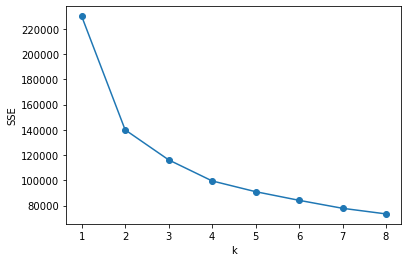

<Figure size 432x288 with 0 Axes>

In [160]:
sse_k(sklearn.preprocessing.scale(score_for_cluster), "score")

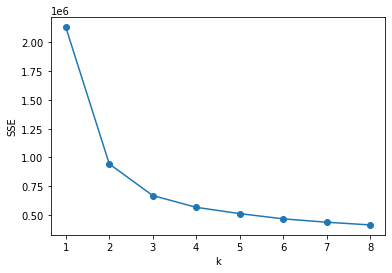

<Figure size 432x288 with 0 Axes>

In [161]:
sse_k(shap_for_cluster,"shap")

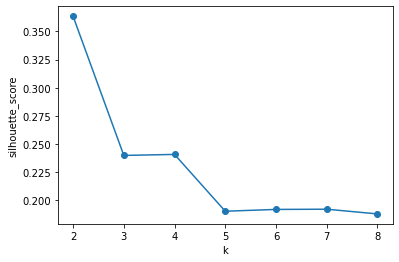

<Figure size 432x288 with 0 Axes>

In [164]:
silhouette_k(sklearn.preprocessing.scale(score_for_cluster),"score")

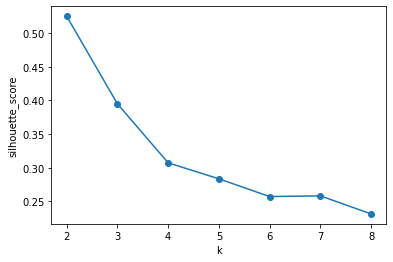

<Figure size 432x288 with 0 Axes>

In [165]:
silhouette_k(shap_for_cluster,"shap")

In [21]:
cluster_result_shap3=KMeans(n_clusters=3).fit(shap_for_cluster)
cluster_result_score3=KMeans(n_clusters=3).fit(sklearn.preprocessing.scale(score_for_cluster))

In [22]:
cluster_result_shap4=KMeans(n_clusters=4).fit(shap_for_cluster)
cluster_result_score4=KMeans(n_clusters=4).fit(sklearn.preprocessing.scale(score_for_cluster))

In [152]:
import matplotlib as mpl
# flatui = ["#9b59b6", "#3498db", "#95a5a6"]
# palette=sns.color_palette(flatui)
def cluster_plt(clusterdf, column_name, n,figname):
    cmap = plt.cm.Set3  # define the colormap
    cmaplist = [cmap(i) for i in range(1,n+1)]# extract n colors from the .jet map
    # what cmaplist[0] likes: = (.5, .5, .5, 1.0)

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, n)

    bounds = np.linspace(0, n, n+1)#the boundary of the color bar is 0 to n
    norm = mpl.colors.BoundaryNorm(bounds, n) #apply the above bound to the color bar
    visualise=pd.concat([pd.DataFrame({"cluster":clusterdf.labels_,
                                        "imd_decile":IndicesPd['Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)']
                                      }),IndicesPd['LSOA code (2011)']],axis=1)
    visualise.set_index("LSOA code (2011)",drop=True, inplace = True)
    lsoa_cluster = lsoa_boundry.join(visualise, on="lsoa11cd", how='right')
    
    lsoa_cluster=lsoa_cluster.join(london.set_index("lsoa11"), on="lsoa11cd", how='left')
    lsoa_cluster.to_crs("epsg:27700")
    fig, ax = plt.subplots(1,1, figsize=(14,18))
    lsoa_cluster.plot(edgecolor=None, column=column_name,linewidth=0.5, cmap=cmap, norm=norm,
             legend=True, ax=ax)
    ax1 = fig.add_axes([0.11, 0.353, 0.29, 0.29])
    lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(edgecolor=None, column=column_name, cmap=cmap,norm=norm, ax=ax1)
    lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(facecolor='none', edgecolor='b',linewidth=0.05,norm=norm, ax=ax)
    # plt.colorbar(fraction=0.05, pad=0.05)
    ax.axis('off')
    ax1.axis('off')
    plt.savefig(f'map {figname}{n}')

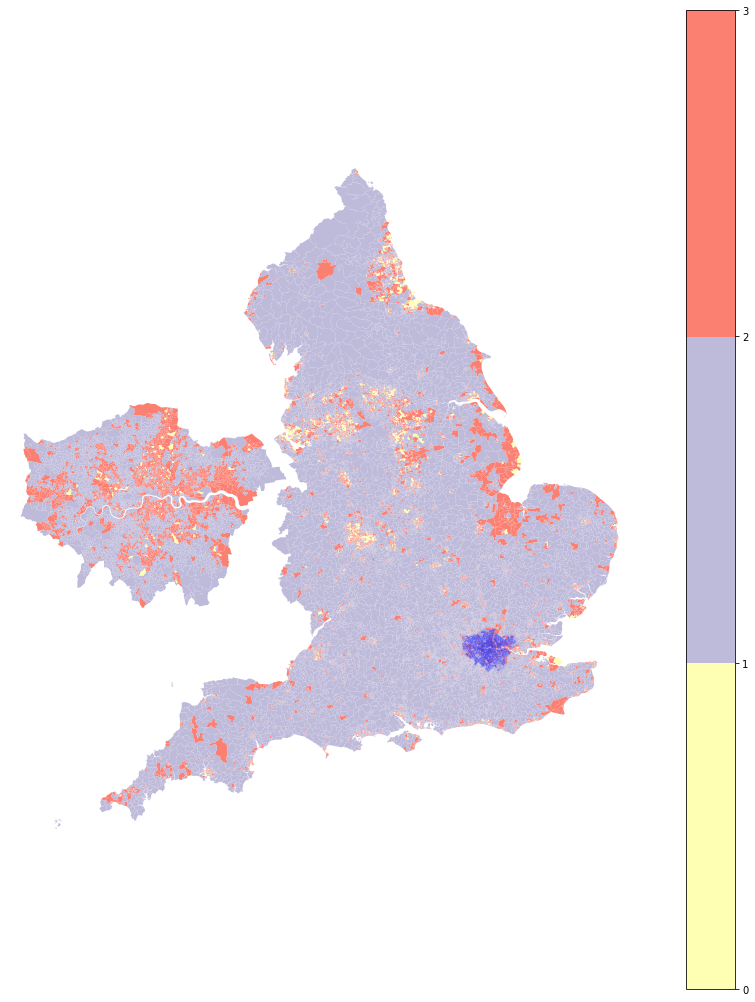

In [148]:
cluster_plt(cluster_result_shap3, "cluster", 3,'shap')

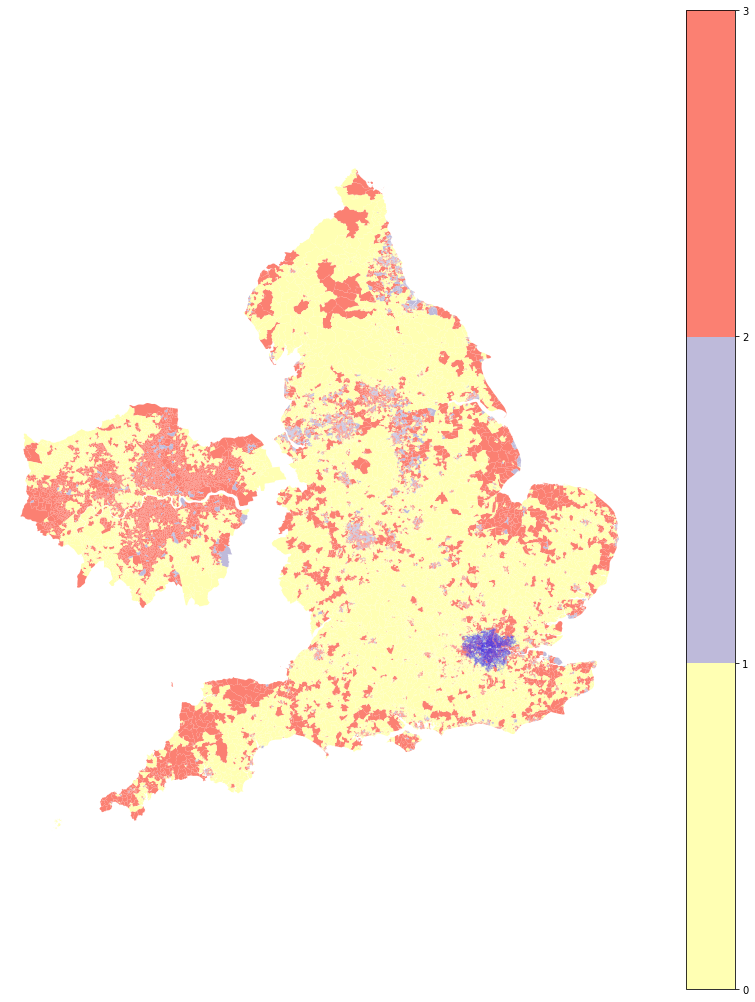

In [149]:
cluster_plt(cluster_result_score3, "cluster",3,'score')

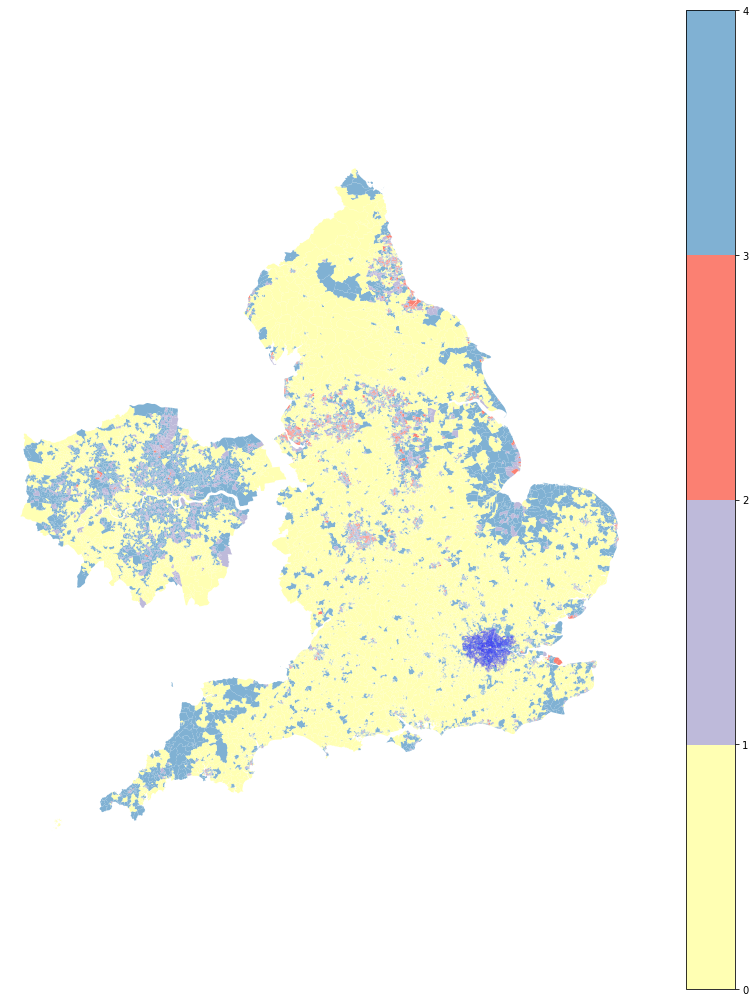

In [150]:
cluster_plt(cluster_result_shap4, "cluster",4,'shap')

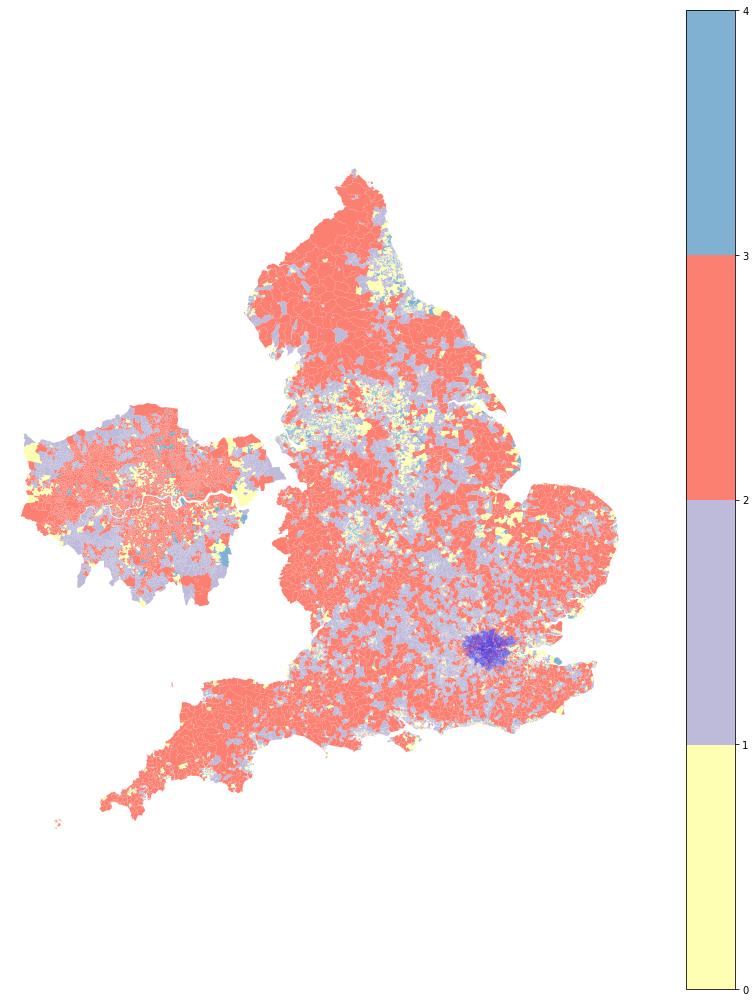

In [151]:
cluster_plt(cluster_result_score4, "cluster",4,"score")

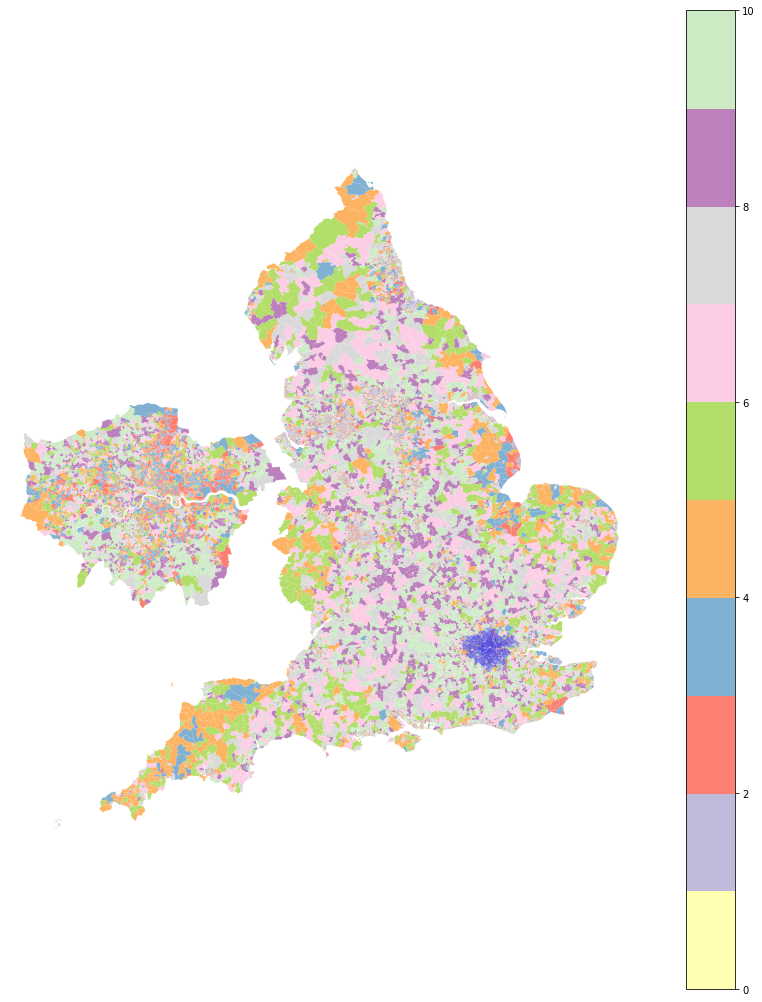

In [153]:
cluster_plt(cluster_result_score4, "imd_decile",10,'imd_decile')

In [67]:
from sklearn import metrics
ARI3 = metrics.adjusted_rand_score(cluster_result_score3.labels_ ,cluster_result_shap3.labels_)
ARI4 = metrics.adjusted_rand_score(cluster_result_score4.labels_ ,cluster_result_shap4.labels_)
print(ARI3)
print(ARI4)

0.5328169759707629
0.4545592808224779


In [42]:
def center(df):
    centerdf=df.cluster_centers_
    min_max_scale=sklearn.preprocessing.MinMaxScaler() # 创建MinMaxScaler对象
    data=min_max_scale.fit_transform(centerdf)
    return data
shap4cluster=center(cluster_result_shap4)    
shap3cluster=center(cluster_result_shap3) 
score4cluster=center(cluster_result_score4)
score3cluster=center(cluster_result_score3)
# sklearn.preprocessing.MinMaxScaler.fit_transform(jj)

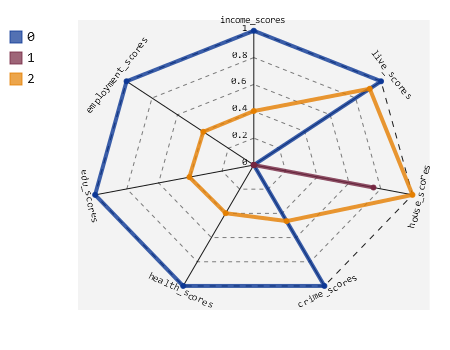

In [106]:
import pygal
from pygal.style import CleanStyle
#准备数据


#准备标签

labels = ['0','1','2']

#创建pygal.Radar对象(雷达图)

radar = pygal.Radar(stroke_style={'width': 4,  'linejoin': 'round'},style=CleanStyle,width=450, height=350,dot_size=5)
radar.x_labels=shap_for_cluster.columns 

#采用循环为雷达图添加数据

for i,per in enumerate(labels):

    radar.add(labels[i],shap3cluster[i])

radar




In [126]:
def radar_plot(labels, cluster_centers, who):
    

    #创建pygal.Radar对象(雷达图)

    radar = pygal.Radar(stroke_style={'width': 3.5,  'linejoin': 'round'},style=CleanStyle,width=500, height=400,dots_size=4)
    radar.x_labels=shap_for_cluster.columns 
    for i,per in enumerate(labels):
        radar.add(labels[i],cluster_centers[i])
    # radar.title="radar plot for 4 clusters in shap"
    # radar.dot_size=28
    radar.render_to_file(f"radar plot for {len(labels)} clusters in {who}.svg")
    radar

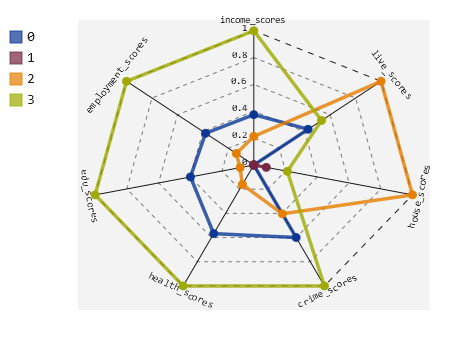

In [129]:
radar_plot( ['0','1','2','3'],score4cluster,'score')

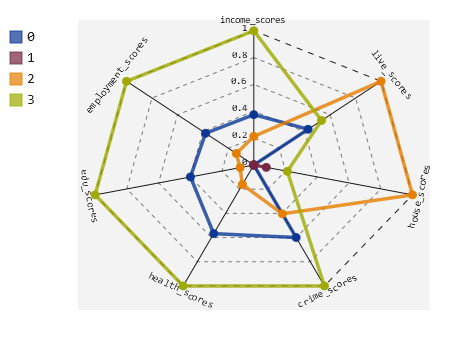

In [130]:
radar_plot( ['0','1','2'],score3cluster,'score')

In [134]:
radar_plot( ['0','1','2'],shap3cluster,'shap')

In [135]:
radar_plot( ['0','1','2','3'],shap4cluster,'shap')